<a href="https://colab.research.google.com/github/areias/healthcare_fraud/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wandb -qqq


     |████████████████████████████████| 1.7 MB 8.3 MB/s 
     |████████████████████████████████| 180 kB 49.1 MB/s 
     |████████████████████████████████| 97 kB 5.5 MB/s 
     |████████████████████████████████| 142 kB 55.4 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import wandb
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean, std,  argmax

In [ ]:
wandb.login()

In [4]:
df_ben=pd.read_csv('Train_Beneficiarydata-1542865627584.csv')
df_in=pd.read_csv('Train_Inpatientdata-1542865627584.csv')
df_out=pd.read_csv('Train_Outpatientdata-1542865627584.csv')
df=pd.read_csv('Train-1542865627584.csv')

In [4]:
df

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No
...,...,...
5405,PRV57759,No
5406,PRV57760,No
5407,PRV57761,No
5408,PRV57762,No


**Merging the data**

**Train**

In [5]:
df_in['Claim_type']='Inpatient'
df_out['Claim_type']='Outpatient'

In [6]:
final_df=pd.concat([df_in, df_out])
final_df=pd.merge(df_ben, final_df, on='BeneID')
final_df=pd.merge(final_df, df, on='Provider')

In [7]:
final_df.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Claim_type,PotentialFraud
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient,Yes
1,BENE12511,1944-09-01,NaN,1,1,0,39,510,12,12,2,2,2,2,2,2,1,1,1,2,2,0,0,1250,90,CLM724430,2009-12-11,2009-12-11,PRV55912,600,PHY420794,NaN,NaN,NaN,NaN,0.0,NaN,NaN,V560,V4283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes
2,BENE14577,1935-10-01,NaN,2,1,Y,33,70,12,12,2,1,1,2,2,2,2,1,2,2,1,0,0,2390,440,CLM567180,2009-09-07,2009-09-07,PRV55912,20,PHY381733,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes
3,BENE15074,1932-06-01,NaN,2,1,0,39,470,12,12,1,2,1,2,2,2,1,1,2,2,2,0,0,870,210,CLM259984,2009-03-22,2009-03-22,PRV55912,30,PHY371570,NaN,PHY393406,NaN,NaN,0.0,NaN,NaN,V812,40390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes
4,BENE16973,1932-05-01,NaN,1,1,0,39,310,12,12,1,1,1,2,2,2,2,1,2,2,2,24000,2136,450,200,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,NaN,NaN,NaN,0.0,NaN,NaN,V7183,53081,78959,4280,E8788,78079,79902,25002,71848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes


In [8]:
final_df.shape

(558211, 56)

In [9]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 56 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   DOB                              558211 non-null  object 
 2   DOD                              4131 non-null    object 
 3   Gender                           558211 non-null  int64  
 4   Race                             558211 non-null  int64  
 5   RenalDiseaseIndicator            558211 non-null  object 
 6   State                            558211 non-null  int64  
 7   County                           558211 non-null  int64  
 8   NoOfMonths_PartACov              558211 non-null  int64  
 9   NoOfMonths_PartBCov              558211 non-null  int64  
 10  ChronicCond_Alzheimer            558211 non-null  int64  
 11  ChronicCond_Heartfailure         558211 non-null  int64  
 12  Ch

**Usage of the date variables:**

In [7]:
# Convert the column Date into Datetime64 datatype
final_df['ClaimStartDt'] = pd.to_datetime(final_df['ClaimStartDt'], format = '%Y-%m-%d')
final_df['ClaimEndDt'] = pd.to_datetime(final_df['ClaimEndDt'], format = '%Y-%m-%d')

In [8]:
final_df['ClaimDuration']= final_df['ClaimEndDt']-final_df['ClaimStartDt']

## First Logistic model Try: 

In [ ]:
model_df=final_df[['IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'ClaimDuration', 'Claim_type', 'InscClaimAmtReimbursed', 'PotentialFraud']]

In [ ]:
model_df

,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimDuration,Claim_type,InscClaimAmtReimbursed,PotentialFraud
0,36000,3204,60,70,6 days,Inpatient,26000,Yes
1,0,0,1250,90,0 days,Outpatient,600,Yes
2,0,0,2390,440,0 days,Outpatient,20,Yes
3,0,0,870,210,0 days,Outpatient,30,Yes
4,24000,2136,450,200,0 days,Outpatient,50,Yes
...,...,...,...,...,...,...,...,...
558206,15000,1068,2540,400,0 days,Outpatient,1900,No
558207,0,0,14240,2810,20 days,Outpatient,2100,No
558208,0,0,640,350,0 days,Outpatient,10,No
558209,0,0,3220,1270,0 days,Outpatient,60,No


In [ ]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype          
---  ------                    --------------   -----          
 0   IPAnnualReimbursementAmt  558211 non-null  int64          
 1   IPAnnualDeductibleAmt     558211 non-null  int64          
 2   OPAnnualReimbursementAmt  558211 non-null  int64          
 3   OPAnnualDeductibleAmt     558211 non-null  int64          
 4   ClaimDuration             558211 non-null  timedelta64[ns]
 5   Claim_type                558211 non-null  object         
 6   InscClaimAmtReimbursed    558211 non-null  int64          
 7   PotentialFraud            558211 non-null  object         
dtypes: int64(5), object(2), timedelta64[ns](1)
memory usage: 38.3+ MB


In [ ]:
feature_names = list(model_df.columns.values)
feature_names.pop(-1)
labels=list(model_df.PotentialFraud.unique())

In [ ]:
model_df['Claim_type']=pd.get_dummies(model_df['Claim_type'])
model_df['PotentialFraud']=pd.get_dummies(model_df['PotentialFraud'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
model_df['ClaimDuration'] = model_df['ClaimDuration'].dt.days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data = model_df.drop(['PotentialFraud'], axis=1)
target = model_df['PotentialFraud']

In [ ]:
final_df['PotentialFraud'].value_counts()

No     345415
Yes    212796
Name: PotentialFraud, dtype: int64

In [ ]:
target.value_counts()

1    345415
0    212796
Name: PotentialFraud, dtype: int64

**Splitting the data:**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=15, stratify=target)

In [ ]:
y_train.value_counts()

1    259061
0    159597
Name: PotentialFraud, dtype: int64

In [ ]:
y_test.value_counts()

1    86354
0    53199
Name: PotentialFraud, dtype: int64

In [ ]:
log_model = LogisticRegression(solver='liblinear', random_state=0)

In [ ]:
log_model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [ ]:
y_pred=log_model.predict(X_test)

In [ ]:
pred_prob = log_model.predict_proba(X_test)
pred_prob

array([[0.5 , 0.5 ],
       [0.56, 0.44],
       [0.37, 0.63],
       ...,
       [0.37, 0.63],
       [0.37, 0.63],
       [0.36, 0.64]])

**Confusion Matrix:**

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Test states')
    plt.xlabel('Predicted states')
    plt.tight_layout()

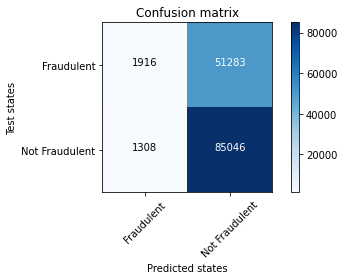

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Fraudulent', 'Not Fraudulent'],
                      title='Confusion matrix')

In [ ]:
accuracy_score(y_test, y_pred)

0.6231467614454723

In [ ]:
f1_score(y_test, y_pred)

0.7638301980842723

In [ ]:
wandb.init(project="Healthcare_fraud")

In [ ]:
wandb.sklearn.plot_confusion_matrix(y_test, y_pred, labels)

In [ ]:
wandb.sklearn.plot_classifier(log_model, X_train, X_test, y_train, y_test, y_pred, pred_prob, labels,
                                                         model_name='LR', feature_names=None)

wandb: 
wandb: Plotting LR.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
wandb: Logged feature importances.
wandb: Logged confusion matrix.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
wandb: Logged summary metrics.
wandb: Logged class proportions.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
wandb: Logged calibration curve.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: Logged roc curve.
w

In [ ]:
wandb.sklearn.plot_roc(y_test, pred_prob, labels)

wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.


In [ ]:
wandb.sklearn.plot_learning_curve(log_model, X_test, y_test)

In [ ]:
wandb.sklearn.plot_class_proportions(y_train, y_test, labels)

In [ ]:
wandb.sklearn.plot_precision_recall(y_test, pred_prob, labels)

In [ ]:
wandb.sklearn.plot_feature_importances(log_model, feature_names)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
wandb.sklearn.plot_summary_metrics(log_model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


## New logistic regression model: 

In [9]:
groups1 = final_df.groupby(['Provider'], as_index=False)['ClaimID'].count()
groups1

,Provider,ClaimID
0,PRV51001,25
1,PRV51003,132
2,PRV51004,149
3,PRV51005,1165
4,PRV51007,72
...,...,...
5405,PRV57759,28
5406,PRV57760,22
5407,PRV57761,82
5408,PRV57762,1


In [10]:
groups2 = final_df.groupby(['Provider'], as_index=False)['IPAnnualDeductibleAmt'].mean()
groups2

,Provider,IPAnnualDeductibleAmt
0,PRV51001,897.120000
1,PRV51003,931.424242
2,PRV51004,434.953020
3,PRV51005,379.162232
4,PRV51007,445.000000
...,...,...
5405,PRV57759,457.714286
5406,PRV57760,436.909091
5407,PRV57761,586.097561
5408,PRV57762,1068.000000


In [11]:
groups3 = final_df.groupby(['Provider'], as_index=False)['OPAnnualDeductibleAmt'].mean()
groups3 

,Provider,OPAnnualDeductibleAmt
0,PRV51001,463.920000
1,PRV51003,737.121212
2,PRV51004,622.751678
3,PRV51005,636.328755
4,PRV51007,469.722222
...,...,...
5405,PRV57759,886.785714
5406,PRV57760,805.454545
5407,PRV57761,707.317073
5408,PRV57762,400.000000


In [12]:
#What is the most common claim type for each provider
groups4=final_df.groupby(['Provider', 'PotentialFraud'], as_index=False)['Claim_type'].agg(pd.Series.mode)
groups4

,Provider,PotentialFraud,Claim_type
0,PRV51001,No,Outpatient
1,PRV51003,Yes,Outpatient
2,PRV51004,No,Outpatient
3,PRV51005,Yes,Outpatient
4,PRV51007,No,Outpatient
...,...,...,...
5405,PRV57759,No,Outpatient
5406,PRV57760,No,Outpatient
5407,PRV57761,No,Outpatient
5408,PRV57762,No,Outpatient


In [13]:
final_df['ClaimDuration'] = final_df['ClaimDuration'].dt.days
groups5 = final_df.groupby(['Provider'], as_index=False)['ClaimDuration'].mean()
groups5

,Provider,ClaimDuration
0,PRV51001,1.440000
1,PRV51003,3.674242
2,PRV51004,1.429530
3,PRV51005,1.088412
4,PRV51007,0.958333
...,...,...
5405,PRV57759,2.142857
5406,PRV57760,0.318182
5407,PRV57761,1.390244
5408,PRV57762,0.000000


In [14]:
Alz = final_df.loc[final_df['ChronicCond_Alzheimer']==2].groupby(['Provider'], as_index=False)['ChronicCond_Alzheimer'].count()
Alz

,Provider,ChronicCond_Alzheimer
0,PRV51001,10
1,PRV51003,76
2,PRV51004,85
3,PRV51005,739
4,PRV51007,46
...,...,...
5260,PRV57759,14
5261,PRV57760,19
5262,PRV57761,46
5263,PRV57762,1


In [15]:
Dep = final_df.loc[final_df['ChronicCond_Depression']==2].groupby(['Provider'], as_index=False)['ChronicCond_Depression'].count()
Dep

,Provider,ChronicCond_Depression
0,PRV51001,16
1,PRV51003,78
2,PRV51004,86
3,PRV51005,680
4,PRV51007,43
...,...,...
5246,PRV57759,19
5247,PRV57760,15
5248,PRV57761,44
5249,PRV57762,1


In [16]:
heart = final_df.loc[final_df['ChronicCond_Heartfailure']==2].groupby(['Provider'], as_index=False)['ChronicCond_Heartfailure'].count()
heart

,Provider,ChronicCond_Heartfailure
0,PRV51001,6
1,PRV51003,52
2,PRV51004,61
3,PRV51005,485
4,PRV51007,32
...,...,...
5094,PRV57759,8
5095,PRV57760,11
5096,PRV57761,26
5097,PRV57762,1


### Merging the new variables

In [17]:
from functools import reduce
pdList = [groups1, groups2, groups3, groups4, groups5, Alz, Dep, heart]  # List of dataframes
new_df = reduce(lambda  left,right: pd.merge(left, right, how="outer" , on=['Provider']),pdList).fillna(0)

In [18]:
new_df

,Provider,ClaimID,IPAnnualDeductibleAmt,OPAnnualDeductibleAmt,PotentialFraud,Claim_type,ClaimDuration,ChronicCond_Alzheimer,ChronicCond_Depression,ChronicCond_Heartfailure
0,PRV51001,25,897.120000,463.920000,No,Outpatient,1.440000,10.0,16.0,6.0
1,PRV51003,132,931.424242,737.121212,Yes,Outpatient,3.674242,76.0,78.0,52.0
2,PRV51004,149,434.953020,622.751678,No,Outpatient,1.429530,85.0,86.0,61.0
3,PRV51005,1165,379.162232,636.328755,Yes,Outpatient,1.088412,739.0,680.0,485.0
4,PRV51007,72,445.000000,469.722222,No,Outpatient,0.958333,46.0,43.0,32.0
...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,28,457.714286,886.785714,No,Outpatient,2.142857,14.0,19.0,8.0
5406,PRV57760,22,436.909091,805.454545,No,Outpatient,0.318182,19.0,15.0,11.0
5407,PRV57761,82,586.097561,707.317073,No,Outpatient,1.390244,46.0,44.0,26.0
5408,PRV57762,1,1068.000000,400.000000,No,Outpatient,0.000000,1.0,1.0,1.0


In [19]:
new_df['ChronicCond_Alzheimer']=new_df['ChronicCond_Alzheimer']*100/new_df['ClaimID']
new_df['ChronicCond_Depression']=new_df['ChronicCond_Depression']*100/new_df['ClaimID']
new_df['ChronicCond_Heartfailure']=new_df['ChronicCond_Heartfailure']*100/new_df['ClaimID']

In [20]:
new_df = new_df.rename(columns={'ClaimID': 'Average_nb_claims', 'IPAnnualDeductibleAmt': 'Avg_IPAnnualDeductibleAmt', 
                                'OPAnnualDeductibleAmt':'Avg_OPAnnualDeductibleAmt', 'Claim_type': 'Most_Common_Claim_Type',
                                'ClaimDuration': 'AvgClaimDuration', 'ChronicCond_Alzheimer': 'Alz_Claims_Ratio',
                                'ChronicCond_Depression': 'Dep_Claims_Ratio', 'ChronicCond_Heartfailure':'Heart_Claims_Ratio'})
new_df = new_df[['Average_nb_claims',	'Avg_IPAnnualDeductibleAmt', 'Avg_OPAnnualDeductibleAmt', 'Most_Common_Claim_Type',	'AvgClaimDuration',	'Alz_Claims_Ratio','Dep_Claims_Ratio', 'Heart_Claims_Ratio', 'PotentialFraud']]
new_df

,Average_nb_claims,Avg_IPAnnualDeductibleAmt,Avg_OPAnnualDeductibleAmt,Most_Common_Claim_Type,AvgClaimDuration,Alz_Claims_Ratio,Dep_Claims_Ratio,Heart_Claims_Ratio,PotentialFraud
0,25,897.120000,463.920000,Outpatient,1.440000,40.000000,64.000000,24.000000,No
1,132,931.424242,737.121212,Outpatient,3.674242,57.575758,59.090909,39.393939,Yes
2,149,434.953020,622.751678,Outpatient,1.429530,57.046980,57.718121,40.939597,No
3,1165,379.162232,636.328755,Outpatient,1.088412,63.433476,58.369099,41.630901,Yes
4,72,445.000000,469.722222,Outpatient,0.958333,63.888889,59.722222,44.444444,No
...,...,...,...,...,...,...,...,...,...
5405,28,457.714286,886.785714,Outpatient,2.142857,50.000000,67.857143,28.571429,No
5406,22,436.909091,805.454545,Outpatient,0.318182,86.363636,68.181818,50.000000,No
5407,82,586.097561,707.317073,Outpatient,1.390244,56.097561,53.658537,31.707317,No
5408,1,1068.000000,400.000000,Outpatient,0.000000,100.000000,100.000000,100.000000,No


In [21]:
new_df['PotentialFraud'].value_counts()

No     4904
Yes     506
Name: PotentialFraud, dtype: int64

In [22]:
feature_names = list(new_df.columns.values)
feature_names.pop(-1)
labels=list(new_df.PotentialFraud.unique())

In [37]:
new_df.dtypes

Average_nb_claims              int64
Avg_IPAnnualDeductibleAmt    float64
Avg_OPAnnualDeductibleAmt    float64
Most_Common_Claim_Type        object
AvgClaimDuration             float64
Alz_Claims_Ratio             float64
Dep_Claims_Ratio             float64
Heart_Claims_Ratio           float64
PotentialFraud                object
dtype: object

### One-hot encoding: 

In [23]:
new_df['Most_Common_Claim_Type']=new_df['Most_Common_Claim_Type'].astype('str')


In [24]:
new_df['Most_Common_Claim_Type']=pd.get_dummies(new_df['Most_Common_Claim_Type'])


In [25]:
new_df["PotentialFraud"].replace({"No": "0", "Yes": "1"}, inplace=True)
new_df['PotentialFraud']=new_df['PotentialFraud'].astype('int')

### Splitting the data: 

In [26]:
data = new_df.drop(['PotentialFraud'], axis=1)
target = new_df['PotentialFraud']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=15, stratify=target)

### Modeling: 

#### Logistic Regression: 

In [28]:
log_model = LogisticRegression(solver='liblinear', random_state=0)

In [29]:
log_model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [30]:
log_pred=log_model.predict(X_test)

In [31]:
pred_prob = log_model.predict_proba(X_test)
pred_prob

array([[0.76519685, 0.23480315],
       [0.96712686, 0.03287314],
       [0.95763332, 0.04236668],
       ...,
       [0.95536776, 0.04463224],
       [0.9781393 , 0.0218607 ],
       [0.94974473, 0.05025527]])

In [32]:
accuracy_score(y_test, log_pred)

0.9068736141906873

In [33]:
f1_score(y_test, log_pred)

0.27586206896551724

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Test states')
    plt.xlabel('Predicted states')
    plt.tight_layout()

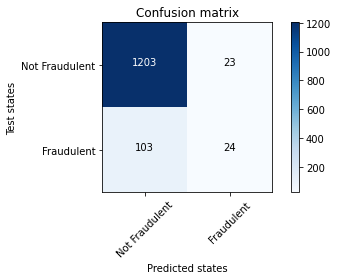

In [35]:
cnf_matrix = confusion_matrix(y_test, log_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[ 'Not Fraudulent', 'Fraudulent',],
                      title='Confusion matrix')

In [36]:
print(metrics.classification_report(y_test, log_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1226
           1       0.51      0.19      0.28       127

    accuracy                           0.91      1353
   macro avg       0.72      0.59      0.61      1353
weighted avg       0.88      0.91      0.89      1353



**ROC Curve**

In [37]:
pred_prob

array([[0.77, 0.23],
       [0.97, 0.03],
       [0.96, 0.04],
       ...,
       [0.96, 0.04],
       [0.98, 0.02],
       [0.95, 0.05]])

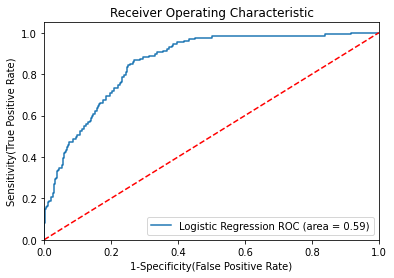

In [42]:
##check! 
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob[:,1])
auc = metrics.roc_auc_score(y_test,log_pred)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('Logistic Regression', auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()  

In [99]:
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.065762


In [103]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

probs = pred_prob[:, 1]
f1_score(y_test, to_labels(probs, best_thresh))

0.3886925795053004

#### Random Forest: 

In [86]:
rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [87]:
rf_pred = rf.predict(X_test)

In [88]:
accuracy_score(y_test, rf_pred)

0.9260901699926091

In [89]:
f1_score(y_test, rf_pred)

0.47916666666666674

In [90]:
print(metrics.classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1226
           1       0.71      0.36      0.48       127

    accuracy                           0.93      1353
   macro avg       0.82      0.67      0.72      1353
weighted avg       0.92      0.93      0.92      1353



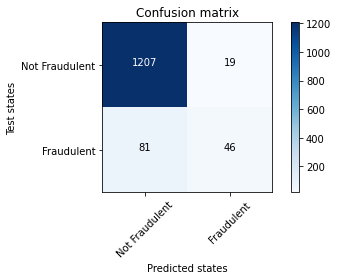

In [91]:
cnf_matrix = confusion_matrix(y_test, rf_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[ 'Not Fraudulent', 'Fraudulent'],
                      title='Confusion matrix')

#### Random Forest Cross Validation

In [92]:
model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('F1_score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

F1_score: 0.513 (0.073)


In [94]:
n_scores

array([0.35, 0.41, 0.43, 0.52, 0.66, 0.58, 0.54, 0.56, 0.57, 0.36, 0.48,
       0.56, 0.5 , 0.48, 0.51, 0.48, 0.6 , 0.57, 0.53, 0.55, 0.54, 0.56,
       0.49, 0.36, 0.57, 0.51, 0.44, 0.57, 0.53, 0.59])